In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

Sin data

In [26]:
def gen_sin_data(data_path, N, T=50, dt=0.1, sig=.1): 
    phis = torch.rand(N,1) #
    fs = torch.rand(N,1) * .5 + .5 # N,1, [0.5, 1.0]
    A  = torch.rand(N,1) * 2 + 1   # N,1, [1.0, 3.0]
    ts = torch.arange(T) * dt # T
    ts = torch.stack([ts]*N)  # N,T
    ts = (ts*fs+phis) * 2*np.pi # N,T
    X  = ts.sin() * A
    X += torch.randn_like(X)*sig
    X = X.unsqueeze(-1)
    return X
	#torch.save(X, data_path)



In [28]:
X = gen_sin_data('', N=1, T=50, dt=0.1, sig=.1)

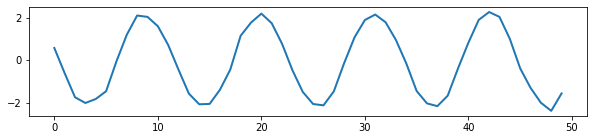

In [29]:

N = min(X.shape[0],6)
D = min(X.shape[-1],3)
Xnp    = X.detach().cpu().numpy()
nc,nr = D, N
fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False)
for n in range(N):
    for d in range(D):
        axes[n,d].plot(Xnp[n,:,d].T, '-', color='tab:blue', lw=2)
plt.show()

Spiral ODE dataset

In [33]:
def gen_spiral_data(data_path, N=500, T=1000, dt=0.01): 
	def odef(t, x, A):
		return (x**3) @ A

	#coefficients
	A  = torch.tensor(np.array([[-0.1, 10.0], [-2.0, -0.1]])) + torch.rand((2,2))*0.1

	#ode
	odef_ = lambda t,x: odef(t,x,A)

	#starting points
	X0 = torch.tensor(np.random.uniform(low=1, high=3, size=(N,2))) 
	X0 = X0 + 1*torch.rand_like(X0)
	ts = torch.arange(T)*dt

	#generate sequences
	Xt = odeint(odef_, X0, ts, method='dopri5') # T,N,dim
	return Xt

In [34]:
xt = gen_spiral_data(')')

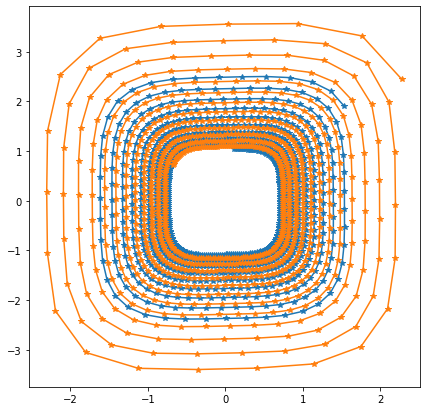

In [35]:
plt.figure(1,(7,7))
for i in range(2):
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()

What the github has

In [ ]:
batch_time = 10
data_size=1000
batch_size=20

In [7]:
s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))

In [14]:
import torch.nn as nn

true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 25., data_size).to(device)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)

In [15]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [16]:
true_y.shape

torch.Size([1000, 1, 2])

In [17]:
batch_y0 = true_y[s]  # (M, D)
batch_t = t[:batch_time]  # (T)
batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)

In [23]:
s

tensor([610, 179, 258, 234, 934, 495,  47, 414, 307, 564, 339, 569, 482, 816,
         59, 459, 543, 941, 691, 591, 770, 724, 635, 624, 354])

In [187]:
batch_y0.shape

torch.Size([25, 1, 2])

they have single ode, as specified above, they have 1000 time points of this sequence, they sample random subsamples of the sequence of length 10 

LV dataset

In [15]:
def gen_lv_data(data_path, N=5, T=100, dt=.1, DIFF=.03, beta=0.5, delta=0.2):
	alpha = torch.rand([N,1]) / .3 + .1
	gamma = torch.rand([N,1]) / .3 + .1

	def odef(t,state,alpha,beta,gamma,delta):
		x,y = state.split([1,1],dim=-1) # M,1 & M,1
		dx = alpha*x   - beta*x*y # M,1
		dy = delta*x*y - gamma*y  # M,1
		return torch.cat([dx,dy],-1)
	
	def _check_valid(x0, xt, N, T, DIFF):
		valid_samples = []
		invalid_samples = []
		for i in range(N):
			initial = x0[i]
			for m in range(T):
				if m != 0: #the initial will always be the same
					frame = xt[m,i]
					for x in torch.abs(frame - initial): #should pass close to the origin dynamics 
						if x< DIFF:
							if i not in valid_samples:
								valid_samples.append(i)
								
			if i not in valid_samples:
				invalid_samples.append(i)
		return valid_samples, invalid_samples

	odef_ = lambda t,x: odef(t,x,alpha,beta,gamma,delta)

	X0 = torch.tensor(np.random.uniform(low=1.0, high=5.0, size=(N,2))) 
	X0 = X0 + 1*torch.rand_like(X0)
	ts = torch.arange(T)*dt

	Xt = odeint(odef_, X0, ts, method='dopri5') # T,N, 2

	valid_s, invalid_s = _check_valid(X0,Xt, N, T, DIFF)
	#disregard invalud samples (trajectory incomplete)
	Xt_valid  = Xt[:,valid_s] # T, N, 2
	#Xt_valid = Xt_valid.permute(1,0,2) #N,T,2
	return Xt_valid

In [18]:
xt = gen_lv_data('-')

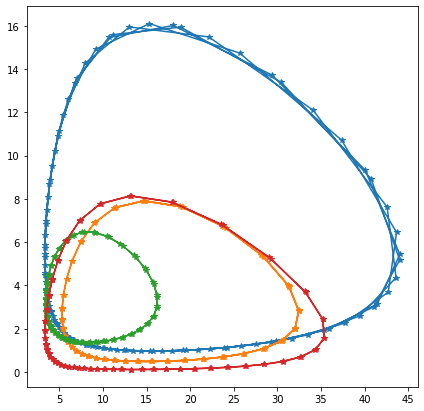

In [19]:
plt.figure(1,(7,7))
for i in range(xt.shape[1]):
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


N = 50
T=100
dt=0.1
DIFF = 0.03

alpha = torch.rand([N,1]) / .3 + .1
gamma = torch.rand([N,1]) / .3 + .1
beta  = 0.5
delta = 0.3

def odef(t,state,alpha,beta,gamma,delta):
    x,y = state.split([1,1],dim=-1) # M,1 & M,1
    dx = alpha*x   - beta*x*y # M,1
    dy = delta*x*y - gamma*y  # M,1
    return torch.cat([dx,dy],-1)

odef_ = lambda t,x: odef(t,x,alpha,beta,gamma,delta)

x0 = torch.tensor(np.random.uniform(low=1.0, high=5.0, size=(N,2))) 
x0 = x0 + 1*torch.rand_like(x0)
ts = torch.arange(T)*dt

xt = odeint(odef_, x0, ts, method='dopri5') # T,N,n

valid_samples = []
invalid_samples = []
for i in range(N):
    initial = x0[i]
    for m in range(T):
        if m != 0: #the initial will always be the same
            frame = xt[m,i]
            for x in torch.abs(frame - initial): #should pass close to the origin dynamics 
                if x< DIFF:
                    if i not in valid_samples:
                        valid_samples.append(i)
                        
    if i not in valid_samples:
        invalid_samples.append(i)

#filter out valid samples 
Xt = xt[:,valid_samples]

In [37]:
Xt.shape

torch.Size([100, 41, 2])

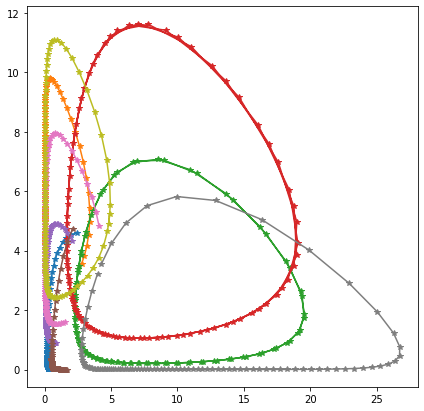

In [38]:
plt.figure(1,(7,7))
for i in invalid_samples:
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()

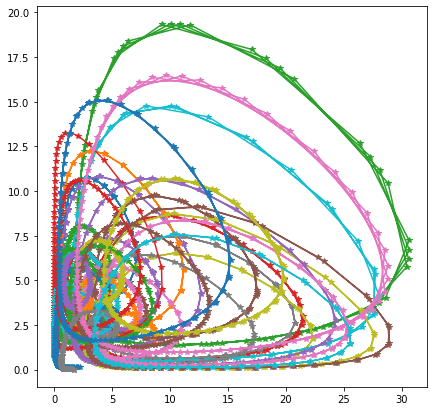

In [39]:
plt.figure(1,(7,7))
for i in valid_samples:
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()

Moving MNIST

In [10]:
def plot_mnist(X, show=False, fname='predictions.png', N=None, Tdata=None):
    if N is None:
        N = min(X.shape[0],10)
    Xnp    = X.detach().cpu().numpy()
    if Tdata is None:
        Tdata  = X.shape[1]
    c = Xnp.shape[-1]
    T=20
    plt.figure(2,(T,3*N))
    for i in range(N):
        for t in range(Tdata):
            plt.subplot(2*N,T,i*T+t+1)
            plt.imshow(np.reshape(Xnp[i,t],[c,c]), cmap='gray')
            plt.xticks([]); plt.yticks([])
    plt.show()

In [3]:
from data.mnist import MovingMNIST

In [19]:
data = MovingMNIST('data/mnist_t/', subsample=50,seq_len=30, num_digits=2)

#generate sequences
N=10
videos = []
for n in range(N):
    videos.append(data._sample_sequence())

#normalize to [0,1] range
Xt = data._collate_fn(videos) #N,T,1,dim,dim

In [20]:
videos[0].shape

(30, 64, 64)

In [6]:
Xt.shape

torch.Size([10, 30, 1, 64, 64])

sanity check

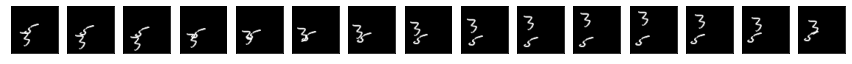

In [9]:
plot_mnist(Xt, N=1, Tdata=15)

Rotating MNIST

In [1]:
from data.mnist import RotatingMNIST

/Users/ilze/PhD/virtualenv/env3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = RotatingMNIST('data/', data_n = 10, n_angles = 16, digit=3)
data._gen_angles()
data._sample_digit()

#generate rotation sequences
videos = data._sample_rotation

#normalize
Xt = data._collate_fn(videos) #N,T,1,dim,dim

sanity check

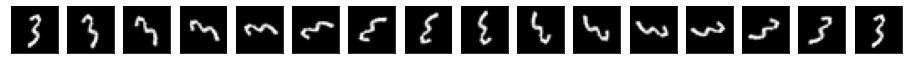

In [11]:
plot_mnist(Xt, N=1, Tdata=16)